# Library file dependencies

In [2]:
import nltk
import inflect
import contractions
import re 
import string 
import unicodedata
import joblib
import warnings
import pickle

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')  

[]

In [4]:
warnings.filterwarnings("ignore")

In [5]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RSCS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RSCS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\RSCS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Preprocessing

In [6]:
def removeNoise(text):
    text = text.lower()
    parser = BeautifulSoup(text, "html.parser")
    text = parser.get_text()
    text = contractions.fix(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@[^\s]+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

def tokenize(text):
    return nltk.word_tokenize(text)

def removeNonaASCII(words):
    newWords = []
    for word in words:
        newWord = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        newWords.append(newWord)
    return newWords

def toLowercase(words):
    newWords = []
    for word in words:
        newWord = word.lower()
        newWords.append(newWord)
    return newWords

def removePunctuation(words):
    newWords = []
    for word in words:
        newWord = re.sub(r'[^\w\s]', '', word)
        if newWord != '':
            newWords.append(newWord)
    return newWords

def replaceNumbers(words):
    engine = inflect.engine()
    newWords = []
    for word in words:
        if word.isdigit():
            newWord = engine.number_to_words(word)
            newWords.append(newWord)
        else:
            newWords.append(word)
    return newWords

def removeStopwords(words):
    newWords = []
    for word in words:
        if word not in stopwords.words('english'):
            newWords.append(word)
    return newWords

def stemWords(words):
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatizeVerbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalizeText(words):
    words = removeNonaASCII(words)
    words = toLowercase(words)
    words = removePunctuation(words)
    words = removeStopwords(words)
    words = stemWords(words)
    words = lemmatizeVerbs(words)
    return words

def processText(text):
    text = removeNoise(text)
    text = ' '.join(normalizeText(tokenize(text)))
    return text

# Dataset Load

In [7]:
data = pd.read_csv('C:/Users/RSCS/Desktop/FYP_train.csv') 

data = data[["text", "target"]]
data.rename(columns = {"text" : "Message", "target" : "Label"}, inplace = True)

print("Number of rows in data:", data.shape[0])
print("Number of columns in data:", data.shape[1])

data.head()

Number of rows in data: 7613
Number of columns in data: 2


,Message,Label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing

In [8]:
data["Message"].apply(processText)
data.head()

,Message,Label
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
data.to_csv("C:/Users/RSCS/Desktop/train_processed.csv")

# TF-IDF Feature Extracter

In [10]:
vectorizer = TfidfVectorizer(
    encoding="utf-8", 
    strip_accents="unicode", 
    stop_words="english", 
    lowercase=True, 
    max_features=500
)
tfidf_result = vectorizer.fit_transform(data["Message"])
tfidf_result.shape

(7613, 500)

In [11]:
pickle.dump(vectorizer, open('C:/Users/RSCS/Desktop/vectorizer.pkl', 'wb'))

In [12]:
FYP_train_X_TFIDF = tfidf_result.toarray()
FYP_train_Y = data["Label"].values


In [13]:
embeddings = {}
glove = open("C:/Users/RSCS/Desktop/glove.6B.50d.txt", encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    try:
        C = np.asarray(values[1:], dtype='float32')
    except:
        pass
    embeddings[word] = C  
glove.close()
pickle.dump(embeddings, open('C:/Users/RSCS/Desktop/glove_embeddings.pkl', 'wb'))
print(f'{len(embeddings)} Word vectors')

400000 Word vectors


# Tokenization

In [14]:
tokenizer = Tokenizer(num_words=75000)
tokenizer.fit_on_texts(data["Message"])
sequences = tokenizer.texts_to_sequences(data["Message"])
paddedSequence = pad_sequences(sequences, maxlen=500)
wordIndex = tokenizer.word_index
print(f'{len(wordIndex)} Unique tokens')
pickle.dump(tokenizer, open('C:/Users/RSCS/Downloads/spam-sms-mnb-model.pkl', 'wb'))

22700 Unique tokens


# Padding

In [15]:
FYP_train_X_SEQ = paddedSequence

In [16]:
FYP_train_X_SEQ.shape

(7613, 500)

In [17]:
FYP_train_X_TFIDF.shape

(7613, 500)

In [18]:
FYP_train_Y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [19]:
FYP_train_Y.shape

(7613,)

# Spam Detection

In [20]:
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score,fbeta_score, precision_score, recall_score, roc_curve, auc

In [21]:
%matplotlib inline
sns.set_theme()

In [22]:
X = FYP_train_X_TFIDF
Y = FYP_train_Y

print("X Shape:", X.shape)
print("Y Shape:", Y.shape)

X Shape: (7613, 500)
Y Shape: (7613,)


# Machine Learning Models

In [23]:
models = {
    "logistic_regression": {
        "instance": LogisticRegression(max_iter=500),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
        }
    },
    "multinominal_naive_bayes": {
        "instance": MultinomialNB(),
        "params": { }
    },
    "decision_tree": {
        "instance": DecisionTreeClassifier(),
        "params": { 
            "criterion" : ["gini"]
        }
    },
    "random_forest": {
        "instance": RandomForestClassifier(),
        "params": {
            "n_estimators": [1, 10, 100, 1000]
        }
    },
    "svm_linear": {
        "instance": SVC(probability=True, gamma="auto", kernel="linear"),
        "params": {
            "C": [1, 10, 100],
        }
    },
    "svm_rbf": {
        "instance": SVC(probability=True, kernel="rbf"),
        "params": {
            "C": [1, 10, 100],
            "gamma": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        }
    },
    
}

# Machine Learning Model Training

In [24]:
scores = []
best_estimators = {}

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)

for model_name, config in models.items():
    print("Training", model_name)
    classifier = GridSearchCV(
        estimator=config["instance"],
        param_grid=config["params"],
        cv=5,
        scoring="accuracy"
    )
    
    classifier.fit(X_train, Y_train)
    
    scores.append({
        "model" : model_name,
        "train_score" : classifier.best_score_,
        "test_score" : classifier.best_estimator_.score(X_test, Y_test),
        "params" : classifier.best_params_
    })
    
    best_estimators[model_name] = classifier.best_estimator_

Training logistic_regression
Training multinominal_naive_bayes
Training decision_tree
Training random_forest
Training svm_linear
Training svm_rbf


In [25]:
result = pd.DataFrame(scores, columns=["model", "train_score", "test_score", "params"])
result.head()

,model,train_score,test_score,params
0,logistic_regression,0.778717,0.782152,{'C': 10}
1,multinominal_naive_bayes,0.767624,0.772966,{}
2,decision_tree,0.725440,0.711286,{'criterion': 'gini'}
3,random_forest,0.772003,0.763780,{'n_estimators': 1000}
4,svm_linear,0.777987,0.775591,{'C': 10}


# Machine Learning Model Test Split

In [26]:
test_split_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

def train(X, Y, Classifier, name, params={}):
    scores = {}
    
    print("Training", name, "\n")
    
    for size in test_split_sizes:    
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = size, random_state = 1)
        
        model = Classifier(**params)
        model.fit(X_train, Y_train)
        
        Y_pred = model.predict(X_test)

        
        scores["{:.0f}%".format(size * 100)] = {
            "Accuracy" : accuracy_score(Y_test, Y_pred),
            "F-0.5": fbeta_score(Y_test,Y_pred, beta=0.5),
            "F-1": fbeta_score(Y_test,Y_pred, beta=1),
            "Precision" : precision_score(Y_test,Y_pred),
            "Recall" : recall_score(Y_test,Y_pred),
            "ROC": roc_curve(Y_test, Y_pred)
        }
        
        idx = "{:.0f}%".format(size * 100)
        
        print("Test Size={:.2f} Accuracy={:.2f} Precision={:.2f} Recall={:.2f} F-1 Score={:.2f} F-0.5 Score={:.2f}".format(size, scores[idx]["Accuracy"], scores[idx]["Accuracy"], scores[idx]["Precision"], scores[idx]["Recall"], scores[idx]["F-1"], scores[idx]["F-0.5"]))
        
        del X_train, X_test, Y_train, Y_test
    
    return scores

# Logistic Regression

In [27]:
logistic_regression_result = train(
    X=X, 
    Y=Y, 
    Classifier=LogisticRegression, 
    name="Logistics Regression",
    params={"C": 1}
)

Training Logistics Regression 

Test Size=0.10 Accuracy=0.78 Precision=0.78 Recall=0.79 F-1 Score=0.64 F-0.5 Score=0.71
Test Size=0.20 Accuracy=0.78 Precision=0.78 Recall=0.79 F-1 Score=0.67 F-0.5 Score=0.72
Test Size=0.30 Accuracy=0.77 Precision=0.77 Recall=0.77 F-1 Score=0.65 F-0.5 Score=0.71
Test Size=0.40 Accuracy=0.77 Precision=0.77 Recall=0.77 F-1 Score=0.65 F-0.5 Score=0.71
Test Size=0.50 Accuracy=0.77 Precision=0.77 Recall=0.77 F-1 Score=0.65 F-0.5 Score=0.70


# Multinomial Naive Bayes

In [28]:
naive_bayes_result = train(
    X=X, 
    Y=Y, 
    Classifier=MultinomialNB, 
    name="Multinomial Naive Bayes",
    params={}
)

Training Multinomial Naive Bayes 

Test Size=0.10 Accuracy=0.77 Precision=0.77 Recall=0.78 F-1 Score=0.65 F-0.5 Score=0.71
Test Size=0.20 Accuracy=0.78 Precision=0.78 Recall=0.78 F-1 Score=0.67 F-0.5 Score=0.72
Test Size=0.30 Accuracy=0.77 Precision=0.77 Recall=0.77 F-1 Score=0.66 F-0.5 Score=0.71
Test Size=0.40 Accuracy=0.76 Precision=0.76 Recall=0.75 F-1 Score=0.65 F-0.5 Score=0.70
Test Size=0.50 Accuracy=0.76 Precision=0.76 Recall=0.75 F-1 Score=0.64 F-0.5 Score=0.69


# DecisionTreeClassifier

In [29]:
decision_tree_result = train(
    X=X, 
    Y=Y, 
    Classifier=DecisionTreeClassifier, 
    name="Decision Tree",
    params={"criterion" : "gini"}
)

Training Decision Tree 

Test Size=0.10 Accuracy=0.70 Precision=0.70 Recall=0.68 F-1 Score=0.58 F-0.5 Score=0.63
Test Size=0.20 Accuracy=0.71 Precision=0.71 Recall=0.67 F-1 Score=0.63 F-0.5 Score=0.65
Test Size=0.30 Accuracy=0.72 Precision=0.72 Recall=0.69 F-1 Score=0.62 F-0.5 Score=0.65
Test Size=0.40 Accuracy=0.72 Precision=0.72 Recall=0.69 F-1 Score=0.62 F-0.5 Score=0.65
Test Size=0.50 Accuracy=0.71 Precision=0.71 Recall=0.66 F-1 Score=0.63 F-0.5 Score=0.65


# Support Vector Machine

In [30]:
svm_result = train(
    X=X, 
    Y=Y, 
    Classifier=SVC, 
    name="Support Vector Machine",
    params={"C": 0.5, "kernel": "linear"}
)

Training Support Vector Machine 

Test Size=0.10 Accuracy=0.78 Precision=0.78 Recall=0.80 F-1 Score=0.65 F-0.5 Score=0.72
Test Size=0.20 Accuracy=0.78 Precision=0.78 Recall=0.79 F-1 Score=0.66 F-0.5 Score=0.72
Test Size=0.30 Accuracy=0.78 Precision=0.78 Recall=0.79 F-1 Score=0.65 F-0.5 Score=0.71
Test Size=0.40 Accuracy=0.77 Precision=0.77 Recall=0.77 F-1 Score=0.63 F-0.5 Score=0.70
Test Size=0.50 Accuracy=0.77 Precision=0.77 Recall=0.78 F-1 Score=0.62 F-0.5 Score=0.70


# Random Forest

In [31]:
random_forest_result = train(
    X=X, 
    Y=Y, 
    Classifier=RandomForestClassifier, 
    name="Random Forest",
    params={"n_estimators" : 1000}
)

Training Random Forest 

Test Size=0.10 Accuracy=0.76 Precision=0.76 Recall=0.75 F-1 Score=0.65 F-0.5 Score=0.69
Test Size=0.20 Accuracy=0.77 Precision=0.77 Recall=0.75 F-1 Score=0.67 F-0.5 Score=0.71
Test Size=0.30 Accuracy=0.78 Precision=0.78 Recall=0.77 F-1 Score=0.67 F-0.5 Score=0.72
Test Size=0.40 Accuracy=0.78 Precision=0.78 Recall=0.77 F-1 Score=0.67 F-0.5 Score=0.72
Test Size=0.50 Accuracy=0.77 Precision=0.77 Recall=0.75 F-1 Score=0.67 F-0.5 Score=0.71


In [32]:
def export_result(result, name):
    table = pd.DataFrame(columns=["Test Size", "Accuracy", "Precision", "Recall", "F-1 Score", "F-0.5 Score"])
    
    for test_size in result:
        table.loc[table.shape[0]] = [
            test_size, 
            round(result[test_size]["Accuracy"], 3), 
            round(result[test_size]["Precision"], 3), 
            round(result[test_size]["Recall"], 3), 
            round(result[test_size]["F-1"], 3), 
            round(result[test_size]["F-0.5"], 3)
        ]
    
    table.to_csv("C:/Users/RSCS/Desktop/Accuracy.csv")
    
    return table

In [33]:
import os

In [34]:
logistic_regression_result = export_result(logistic_regression_result, "Logistic Regression")
naive_bayes_result = export_result(naive_bayes_result, "Naive Bayes")
decision_tree_result = export_result(decision_tree_result, "Decision Tree")
svm_result = export_result(svm_result, "SVM")
random_forest_result = export_result(random_forest_result, "Random Forest")

In [35]:
logistic_regression_result

,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,10%,0.776,0.791,0.642,0.709,0.756
1,20%,0.785,0.786,0.671,0.724,0.760
2,30%,0.773,0.771,0.652,0.707,0.744
3,40%,0.773,0.767,0.654,0.706,0.741
4,50%,0.769,0.768,0.649,0.704,0.741


In [36]:
naive_bayes_result

,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,10%,0.773,0.777,0.654,0.710,0.749
1,20%,0.780,0.776,0.671,0.720,0.753
2,30%,0.773,0.768,0.657,0.708,0.743
3,40%,0.764,0.753,0.646,0.696,0.729
4,50%,0.761,0.755,0.642,0.694,0.729


In [37]:
decision_tree_result

,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,10%,0.703,0.675,0.583,0.626,0.654
1,20%,0.712,0.668,0.627,0.647,0.659
2,30%,0.723,0.687,0.624,0.654,0.673
3,40%,0.722,0.685,0.616,0.649,0.670
4,50%,0.707,0.660,0.631,0.645,0.654


In [38]:
svm_result

,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,10%,0.782,0.802,0.648,0.717,0.765
1,20%,0.783,0.791,0.660,0.719,0.761
2,30%,0.779,0.785,0.652,0.713,0.754
3,40%,0.768,0.768,0.635,0.695,0.737
4,50%,0.769,0.784,0.625,0.695,0.746


In [39]:
random_forest_result

,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,10%,0.757,0.749,0.645,0.693,0.726
1,20%,0.770,0.754,0.674,0.712,0.736
2,30%,0.777,0.771,0.667,0.715,0.748
3,40%,0.778,0.769,0.669,0.716,0.747
4,50%,0.766,0.751,0.666,0.706,0.732


In [40]:
def load_result(name):
    result = pd.read_csv("C:/Users/RSCS/Desktop/Accuracy.csv")
    return result

In [41]:
logistic_regression_result = load_result("Logistic Regression")
naive_bayes_result = load_result("Naive Bayes")
decision_tree_result = load_result("Decision Tree")
svm_result = load_result("SVM")
random_forest_result = load_result("Random Forest")

In [42]:
logistic_regression_result

,Unnamed: 0,Test Size,Accuracy,Precision,Recall,F-1 Score,F-0.5 Score
0,0,10%,0.757,0.749,0.645,0.693,0.726
1,1,20%,0.770,0.754,0.674,0.712,0.736
2,2,30%,0.777,0.771,0.667,0.715,0.748
3,3,40%,0.778,0.769,0.669,0.716,0.747
4,4,50%,0.766,0.751,0.666,0.706,0.732


In [43]:
train_split_sizes = 1 - np.array(test_split_sizes)

# Accuracy

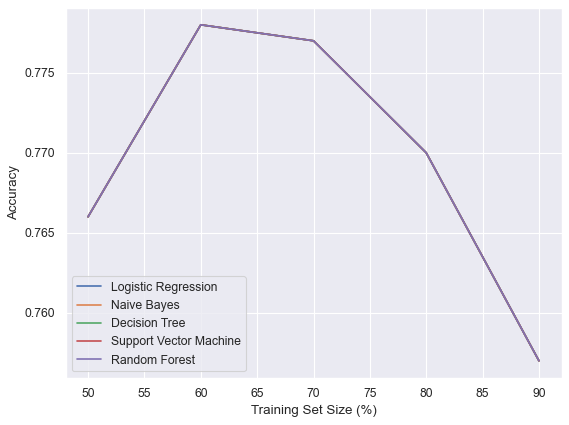

In [44]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, logistic_regression_result["Accuracy"], label="Logistic Regression")
plt.plot(train_split_sizes * 100, naive_bayes_result["Accuracy"], label="Naive Bayes")
plt.plot(train_split_sizes * 100, decision_tree_result["Accuracy"], label="Decision Tree")
plt.plot(train_split_sizes * 100, svm_result["Accuracy"], label="Support Vector Machine")
plt.plot(train_split_sizes * 100, random_forest_result["Accuracy"], label="Random Forest")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Accuracy")

plt.legend()

plt.show()

# Precision

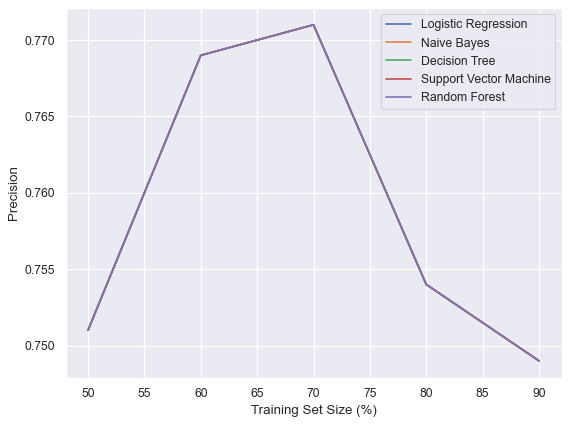

In [45]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, logistic_regression_result["Precision"], label="Logistic Regression")
plt.plot(train_split_sizes * 100, naive_bayes_result["Precision"], label="Naive Bayes")
plt.plot(train_split_sizes * 100, decision_tree_result["Precision"], label="Decision Tree")
plt.plot(train_split_sizes * 100, svm_result["Precision"], label="Support Vector Machine")
plt.plot(train_split_sizes * 100, random_forest_result["Precision"], label="Random Forest")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Precision")

plt.legend()

plt.show()

# Recall

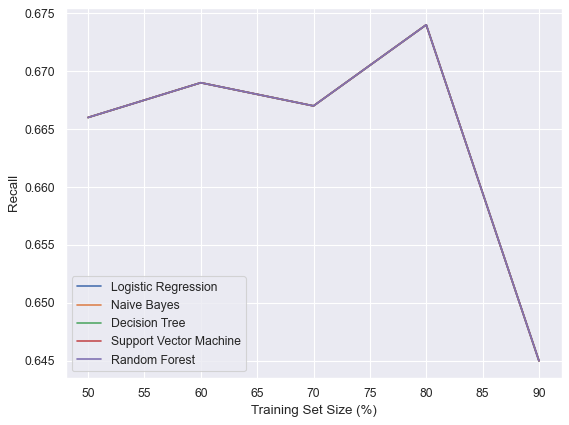

In [46]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, logistic_regression_result["Recall"], label="Logistic Regression")
plt.plot(train_split_sizes * 100, naive_bayes_result["Recall"], label="Naive Bayes")
plt.plot(train_split_sizes * 100, decision_tree_result["Recall"], label="Decision Tree")
plt.plot(train_split_sizes * 100, svm_result["Recall"], label="Support Vector Machine")
plt.plot(train_split_sizes * 100, random_forest_result["Recall"], label="Random Forest")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Recall")

plt.legend()

plt.show()

# F-1 Score

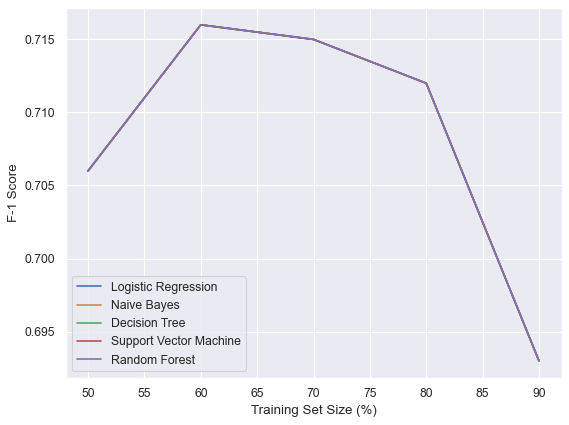

In [47]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, logistic_regression_result["F-1 Score"], label="Logistic Regression")
plt.plot(train_split_sizes * 100, naive_bayes_result["F-1 Score"], label="Naive Bayes")
plt.plot(train_split_sizes * 100, decision_tree_result["F-1 Score"], label="Decision Tree")
plt.plot(train_split_sizes * 100, svm_result["F-1 Score"], label="Support Vector Machine")
plt.plot(train_split_sizes * 100, random_forest_result["F-1 Score"], label="Random Forest")

plt.xlabel("Training Set Size (%)")
plt.ylabel("F-1 Score")

plt.legend()

plt.show()

# F-0.5 Score

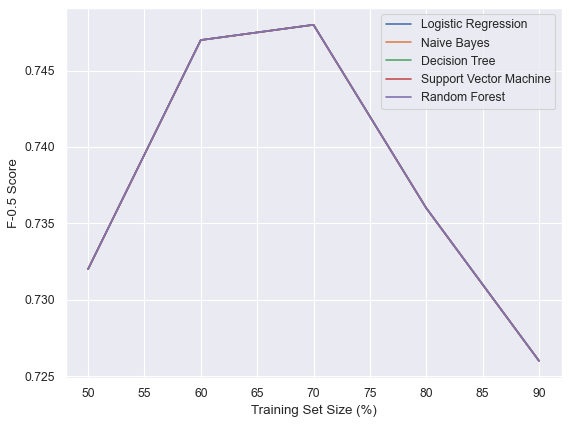

In [48]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, logistic_regression_result["F-0.5 Score"], label="Logistic Regression")
plt.plot(train_split_sizes * 100, naive_bayes_result["F-0.5 Score"], label="Naive Bayes")
plt.plot(train_split_sizes * 100, decision_tree_result["F-0.5 Score"], label="Decision Tree")
plt.plot(train_split_sizes * 100, svm_result["F-0.5 Score"], label="Support Vector Machine")
plt.plot(train_split_sizes * 100, random_forest_result["F-0.5 Score"], label="Random Forest")

plt.xlabel("Training Set Size (%)")
plt.ylabel("F-0.5 Score")

plt.legend()

plt.show()

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)

In [50]:
logistic_regression_model = LogisticRegression()
naive_bayes_model = MultinomialNB()
decision_tree_model = DecisionTreeClassifier()
svm_model = SVC()
random_forest_model = RandomForestClassifier()

In [51]:
def generate_roc(model, rnd=False):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    FPR, TPR, Threshold = roc_curve(Y_test, Y_pred)
    AUC = auc(FPR, TPR)
    return {"FPR": FPR, "TPR": TPR, "AUC": AUC} 

In [52]:
roc_logistic_regression = generate_roc(logistic_regression_model)
roc_naive_bayes = generate_roc(naive_bayes_model)
roc_svm = generate_roc(svm_model)
roc_decision_tree = generate_roc(decision_tree_model)
roc_random_forest = generate_roc(random_forest_model)

# RoC Comparison

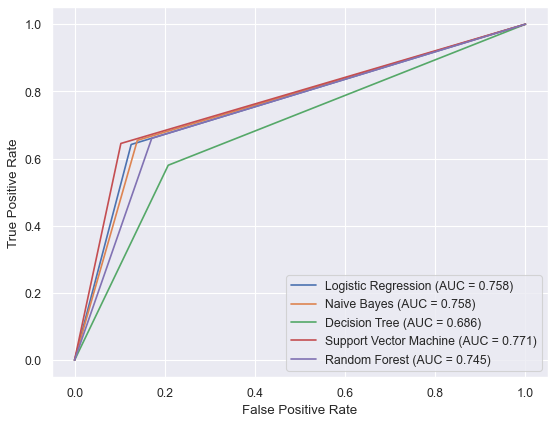

In [53]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(
    roc_logistic_regression['FPR'], 
    roc_logistic_regression['TPR'], 
    label=f'Logistic Regression (AUC = {round(roc_logistic_regression["AUC"], 3)})'
)

plt.plot(
    roc_naive_bayes['FPR'], 
    roc_naive_bayes['TPR'], 
    label=f'Naive Bayes (AUC = {round(roc_naive_bayes["AUC"], 3)})'
)

plt.plot(
    roc_decision_tree['FPR'], 
    roc_decision_tree['TPR'], 
    label=f'Decision Tree (AUC = {round(roc_decision_tree["AUC"], 3)})'
)

plt.plot(
    roc_svm['FPR'], 
    roc_svm['TPR'], 
    label=f'Support Vector Machine (AUC = {round(roc_svm["AUC"], 3)})'
)

plt.plot(
    roc_random_forest['FPR'], 
    roc_random_forest['TPR'], 
    label=f'Random Forest (AUC = {round(roc_random_forest["AUC"], 3)})'
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()

plt.show()

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 1)

# Ensemble Models

In [55]:
BAG_model = BaggingClassifier(base_estimator=MultinomialNB(), n_estimators=500)
BAG_model.fit(X_train, Y_train)
Y_pred = BAG_model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.7742782152230971

In [56]:
GB_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.05, subsample=0.5)
GB_model.fit(X_train, Y_train)
Y_pred = GB_model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.7729658792650919

In [57]:
AB_model = AdaBoostClassifier(base_estimator=MultinomialNB(), n_estimators=500, learning_rate=0.05) # Add parameters
AB_model.fit(X_train, Y_train)
Y_pred = AB_model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.5748031496062992

In [58]:
XGB_model = XGBClassifier(n_estimators=2000, eta=0.05, subsample=0.5, colsample_bytree=0.5)
XGB_model.fit(X_train, Y_train)
Y_pred = XGB_model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.7637795275590551

In [59]:
joblib.dump(XGB_model, "C:/Users/RSCS/Desktop//SDC_GB_MODEL")

['C:/Users/RSCS/Desktop//SDC_GB_MODEL']

# Spam Classification

In [60]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalMaxPooling1D, Conv1D, LSTM, Bidirectional, Dropout
from tensorflow.keras.metrics import CategoricalAccuracy, AUC, Precision, Recall, BinaryAccuracy

In [61]:
%matplotlib inline

sns.set_theme()

In [62]:
X = FYP_train_X_SEQ
Y = FYP_train_Y

In [63]:
tokenizer = pickle.load(open("C:/Users/RSCS/Desktop/tokenizer.pkl",  "rb"))
embeddings = pickle.load(open("C:/Users/RSCS/Desktop/glove_embeddings.pkl", "rb"))

In [64]:
X.shape

(7613, 500)

In [65]:
Y.shape

(7613,)

In [66]:
embeddingMatrix = np.random.random((len(tokenizer.word_index) + 1, 50))
for word, i in tokenizer.word_index.items():
    embeddingVector = embeddings.get(word)
    if embeddingVector is not None:
        if len(embeddingMatrix[i]) != len(embeddingVector):
            print(
                "could not broadcast input array from shape", 
                str(len(embeddingMatrix[i])), 
                "into shape", 
                str(len(embeddingVector)), 
                "Please make sure your"
            )
            exit(1)
        embeddingMatrix[i] = embeddingVector

# DNN

In [67]:
dnn_input_layer = Input(shape=(X.shape[1],))
dnn_embedding_layer = Embedding(len(tokenizer.word_index) + 1, embeddingMatrix.shape[1], trainable=True)(dnn_input_layer)
dnn_maxpool1d_layer = GlobalMaxPooling1D()(dnn_embedding_layer)
dnn_hidden_layer_1 = Dense(200, activation='relu')(dnn_maxpool1d_layer)
dnn_hidden_layer_2 = Dense(100, activation='relu')(dnn_hidden_layer_1)
dnn_hidden_layer_3 = Dense(50, activation='relu')(dnn_hidden_layer_2)
dnn_output_layer = Dense(1, activation='sigmoid')(dnn_hidden_layer_3)

model_dnn = Model(inputs=dnn_input_layer, outputs=dnn_output_layer)

model_dnn.compile(
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=[BinaryAccuracy(name="binary_accuracy"), AUC(name="auc")]
)

In [68]:
model_dnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 50)           1638050   
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 200)               10200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                             

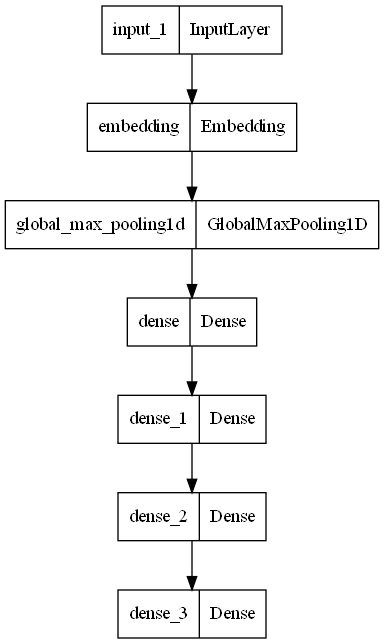

In [69]:
plot_model(model_dnn)

# CNN

In [70]:
cnn_input_layer = Input(shape=(X.shape[1],))
cnn_embedding_layer = Embedding(len(tokenizer.word_index) + 1, embeddingMatrix.shape[1], trainable=True)(cnn_input_layer)
cnn_conv1d_layer = Conv1D(400, 3, padding='valid', activation='relu', strides=1)(cnn_embedding_layer)
cnn_maxpool1d_layer = GlobalMaxPooling1D()(cnn_conv1d_layer)
cnn_hidden_layer_1 = Dense(200, activation='relu')(cnn_maxpool1d_layer)
cnn_hidden_layer_2 = Dense(100, activation='relu')(cnn_hidden_layer_1)
cnn_hidden_layer_3 = Dense(50, activation='relu')(cnn_hidden_layer_2)
cnn_output_layer = Dense(1, activation='sigmoid')(cnn_hidden_layer_3)

model_cnn = Model(inputs=cnn_input_layer, outputs=cnn_output_layer)

model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=[BinaryAccuracy(name="binary_accuracy"), AUC(name="auc")])

In [71]:
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 50)           1638050   
                                                                 
 conv1d (Conv1D)             (None, 498, 400)          60400     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 400)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 200)               80200     
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                           

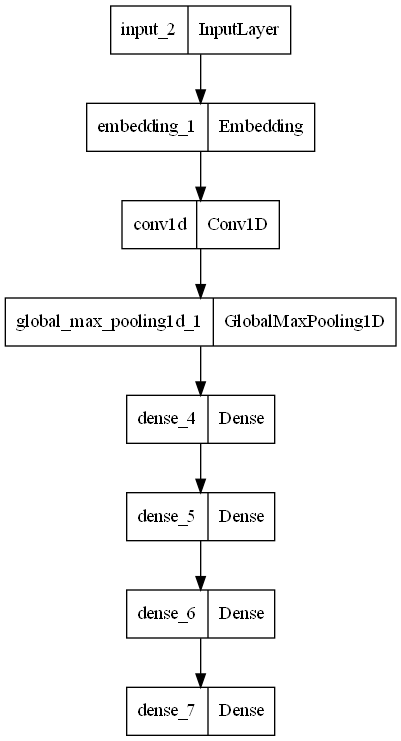

In [72]:
plot_model(model_cnn)

# Bi-LSTM

In [73]:
bilstm_input_layer = Input(shape=(X.shape[1],))
bilstm_embedding_layer = Embedding(len(tokenizer.word_index) + 1, embeddingMatrix.shape[1], trainable=True)(bilstm_input_layer)
bilstm_layer_1 = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2))(bilstm_embedding_layer)
dropout_layer_1 = Dropout(0.2)(bilstm_layer_1)
bilstm_layer_2 = Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.2))(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(bilstm_layer_2)
bilstm_layer_3 = Bidirectional(LSTM(32, recurrent_dropout=0.2))(dropout_layer_2)
dropout_layer_3 = Dropout(0.2)(bilstm_layer_3)
bilstm_hidden_layer_1 = Dense(200, activation='relu')(dropout_layer_3)
bilstm_hidden_layer_2 = Dense(100, activation='relu')(bilstm_hidden_layer_1)
bilstm_hidden_layer_3 = Dense(50, activation='relu')(bilstm_hidden_layer_2)
bilstm_output_layer = Dense(1, activation='sigmoid')(bilstm_hidden_layer_3)

model_bilstm = Model(inputs=bilstm_input_layer, outputs=bilstm_output_layer)

model_bilstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=[BinaryAccuracy(name="binary_accuracy"), AUC(name="auc")])

In [74]:
model_bilstm.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 50)           1638050   
                                                                 
 bidirectional (Bidirection  (None, 500, 64)           21248     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 500, 64)           24832     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0   

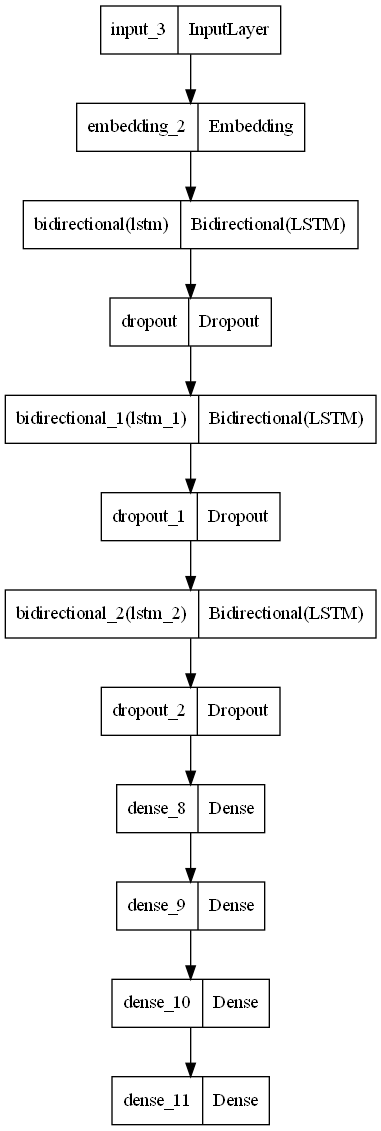

In [75]:
plot_model(model_bilstm)

# Testset Split

In [76]:
test_split_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]

def train(X, Y, model, name):
    scores = {}
    
    print("Training", name, "\n")
    
    initial_weights = model.get_weights()
    
    for size in test_split_sizes:   
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=size, random_state=1)
        
        model.set_weights(initial_weights)

        model.fit(X_train, Y_train, batch_size=32, epochs=3, shuffle=True , validation_split=0.2, verbose=1)
        
        scores["{:.0f}%".format(size * 100)] = { }
                
        result = model.evaluate(X_train, Y_train, verbose=0)
        scores["{:.0f}%".format(size * 100)]["Train"] = {
            "Loss" : result[0],
            "Accuracy" : result[1],
            "AUC" : result[2]
        }

        result = model.evaluate(X_test, Y_test, verbose=0)
        scores["{:.0f}%".format(size * 100)]["Test"] = {
            "Loss" : result[0],
            "Accuracy" : result[1],
            "AUC" : result[2]
        }
        
        idx = "{:.0f}%".format(size * 100)
        
        print("Test Size={:.4f}".format(size))
        print("Train Loss={:.4f} Train Accuracy={:.4f} Train AUC={:.4f}".format(scores[idx]["Train"]["Loss"], scores[idx]["Train"]["Accuracy"], scores[idx]["Train"]["AUC"]))
        print("Test Loss={:.4f} Test Accuracy={:.4f} Test AUC={:.4f}".format(scores[idx]["Test"]["Loss"], scores[idx]["Test"]["Accuracy"], scores[idx]["Test"]["AUC"]))
        print("\n")
        
        del X_train, X_test, Y_train, Y_test
        
    return scores

# DNN Training

In [77]:
dnn_result = train(X, Y, model_dnn, "DNN")

Training DNN 

Epoch 1/3
172/172 [==============================] - 5s 19ms/step - loss: 0.6251 - binary_accuracy: 0.6462 - auc: 0.7031 - val_loss: 0.5415 - val_binary_accuracy: 0.7593 - val_auc: 0.8396
Epoch 2/3
172/172 [==============================] - 3s 17ms/step - loss: 0.3489 - binary_accuracy: 0.8604 - auc: 0.9204 - val_loss: 0.5019 - val_binary_accuracy: 0.7870 - val_auc: 0.8500
Epoch 3/3
172/172 [==============================] - 3s 18ms/step - loss: 0.1530 - binary_accuracy: 0.9453 - auc: 0.9838 - val_loss: 0.5781 - val_binary_accuracy: 0.7622 - val_auc: 0.8426
Test Size=0.1000
Train Loss=0.1556 Train Accuracy=0.9421 Train AUC=0.9835
Test Loss=0.5510 Test Accuracy=0.7795 Test AUC=0.8506


Epoch 1/3
153/153 [==============================] - 3s 19ms/step - loss: 0.6748 - binary_accuracy: 0.5749 - auc: 0.5756 - val_loss: 0.6354 - val_binary_accuracy: 0.6782 - val_auc: 0.7609
Epoch 2/3
153/153 [==============================] - 3s 18ms/step - loss: 0.4701 - binary_accuracy: 0.7

# CNN Training

In [78]:
cnn_result = train(X, Y, model_cnn, "CNN")

Training CNN 

Epoch 1/3
172/172 [==============================] - 11s 56ms/step - loss: 0.5704 - binary_accuracy: 0.7004 - auc: 0.7559 - val_loss: 0.4434 - val_binary_accuracy: 0.8082 - val_auc: 0.8648
Epoch 2/3
172/172 [==============================] - 10s 55ms/step - loss: 0.3069 - binary_accuracy: 0.8827 - auc: 0.9365 - val_loss: 0.4557 - val_binary_accuracy: 0.7958 - val_auc: 0.8596
Epoch 3/3
172/172 [==============================] - 10s 56ms/step - loss: 0.0952 - binary_accuracy: 0.9679 - auc: 0.9924 - val_loss: 0.7325 - val_binary_accuracy: 0.7082 - val_auc: 0.8356
Test Size=0.1000
Train Loss=0.1762 Train Accuracy=0.9337 Train AUC=0.9860
Test Loss=0.7356 Test Accuracy=0.7152 Test AUC=0.8333


Epoch 1/3
153/153 [==============================] - 8s 55ms/step - loss: 0.6589 - binary_accuracy: 0.6127 - auc: 0.6186 - val_loss: 0.6019 - val_binary_accuracy: 0.6995 - val_auc: 0.7882
Epoch 2/3
153/153 [==============================] - 8s 53ms/step - loss: 0.4254 - binary_accuracy: 

# Bi-LSTM

In [79]:
bilstm_result = train(X, Y, model_bilstm, "BiLSTM")

Training BiLSTM 

Epoch 1/3
172/172 [==============================] - 378s 2s/step - loss: 0.5606 - binary_accuracy: 0.7029 - auc: 0.7581 - val_loss: 0.4459 - val_binary_accuracy: 0.8001 - val_auc: 0.8584
Epoch 2/3
172/172 [==============================] - 382s 2s/step - loss: 0.2911 - binary_accuracy: 0.8894 - auc: 0.9392 - val_loss: 0.5110 - val_binary_accuracy: 0.7885 - val_auc: 0.8529
Epoch 3/3
172/172 [==============================] - 395s 2s/step - loss: 0.1191 - binary_accuracy: 0.9608 - auc: 0.9876 - val_loss: 0.8193 - val_binary_accuracy: 0.7272 - val_auc: 0.8267
Test Size=0.1000
Train Loss=0.2151 Train Accuracy=0.9340 Train AUC=0.9804
Test Loss=0.8397 Test Accuracy=0.7139 Test AUC=0.8214


Epoch 1/3
153/153 [==============================] - 361s 2s/step - loss: 0.6838 - binary_accuracy: 0.5716 - auc: 0.5081 - val_loss: 0.6739 - val_binary_accuracy: 0.5525 - val_auc: 0.6613
Epoch 2/3
153/153 [==============================] - 339s 2s/step - loss: 0.5095 - binary_accuracy: 

In [80]:
def export_result(result, name):
    table = pd.DataFrame(columns=["Test Size", "Train Loss", "Train Accuracy", "Train AUC", "Test Loss", "Test Accuracy", "Test AUC"])
    
    for test_size in result:
        table.loc[table.shape[0]] = [
            test_size, 
            round(result[test_size]["Train"]["Loss"], 3), 
            round(result[test_size]["Train"]["Accuracy"], 3), 
            round(result[test_size]["Train"]["AUC"], 3), 
            round(result[test_size]["Test"]["Loss"], 3), 
            round(result[test_size]["Test"]["Accuracy"], 3),
            round(result[test_size]["Test"]["AUC"], 3)
        ]
    
    table.to_csv("C:/Users/RSCS/Desktop/Deeplearning_accuracy.csv")
    
    return table

In [81]:
dnn_result = export_result(dnn_result, "DNN")

In [82]:
cnn_result = export_result(cnn_result, "CNN")

In [83]:
bilstm_result = export_result(bilstm_result, "BiLSTM")

In [84]:
train_split_sizes = 1 - np.array(test_split_sizes)

# Train Accuracy Comparison

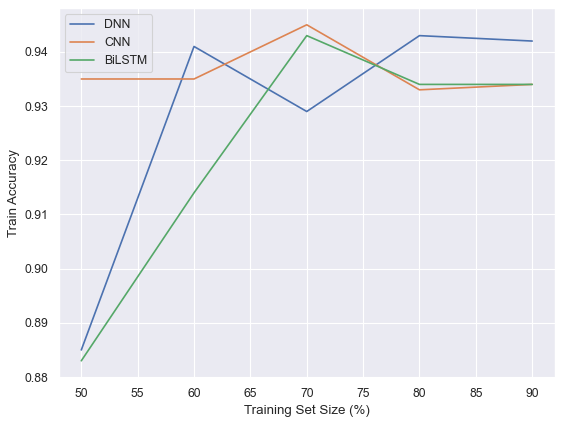

In [85]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Train Accuracy"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Train Accuracy"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Train Accuracy"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Train Accuracy")

plt.legend()

plt.show()

# Test Accuracy Comparison

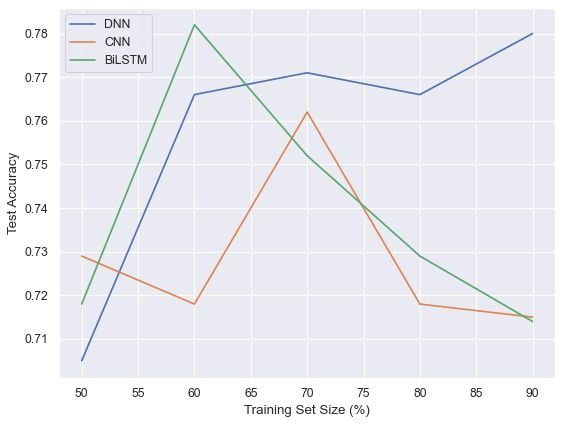

In [86]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Test Accuracy"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Test Accuracy"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Test Accuracy"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Test Accuracy")

plt.legend()

plt.show()

# Training Area Under Curve Comparison

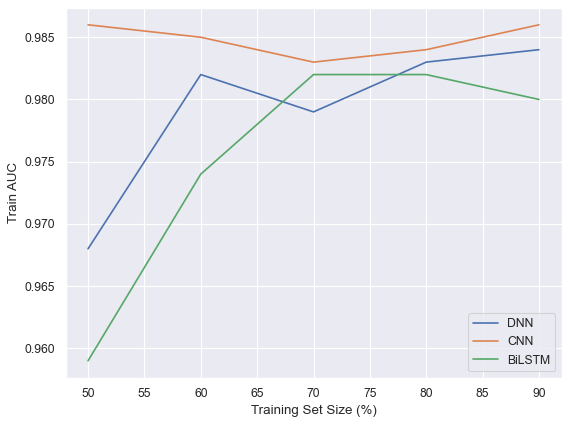

In [87]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Train AUC"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Train AUC"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Train AUC"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Train AUC")

plt.legend()

plt.show()

# Testing Area Under Curve Comparison

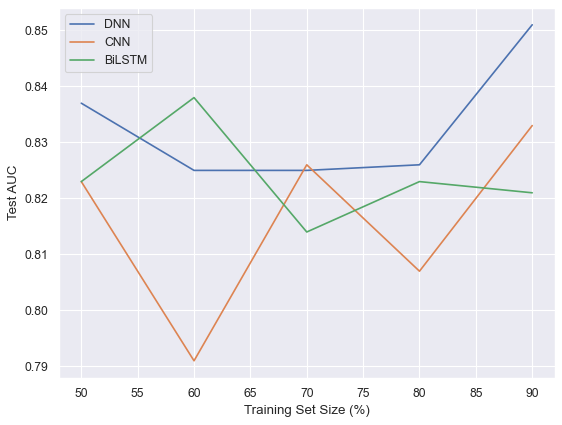

In [88]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Test AUC"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Test AUC"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Test AUC"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Test AUC")

plt.legend()

plt.show()

# Training Loss Comparison

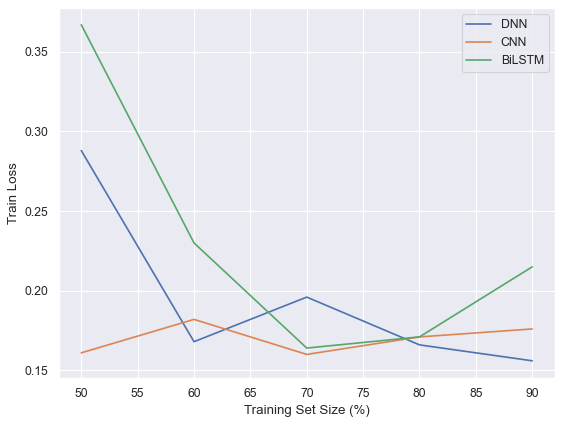

In [89]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Train Loss"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Train Loss"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Train Loss"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Train Loss")

plt.legend()

plt.show()

# Testing Loss Comparison

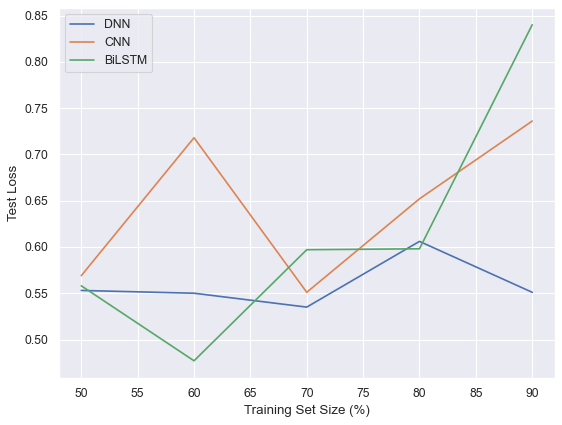

In [90]:
plt.figure(figsize=(8, 6), dpi=80)

plt.plot(train_split_sizes * 100, dnn_result["Test Loss"], label="DNN")
plt.plot(train_split_sizes * 100, cnn_result["Test Loss"], label="CNN")
plt.plot(train_split_sizes * 100, bilstm_result["Test Loss"], label="BiLSTM")

plt.xlabel("Training Set Size (%)")
plt.ylabel("Test Loss")

plt.legend()

plt.show()